## Solving bidomain equations on a slice of the heart

### Importing required libraries

In [1]:
%cd ../../..
from src.models.dynamics_models import *
from src.models.cell_models import *
from src.utils import *
import ufl

/home/drvinko/Desktop/Modeliranje-biofizike-srcanog-tkiva


### Defining a domain, cell model and dynamics model and visualizing initial data

In [2]:
domain = heart_slice()
x = ufl.SpatialCoordinate(domain)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 40%] Meshing curve 2 (Nurb)
Info    : [ 70%] Meshing curve 3 (Nurb)
Info    : Done meshing 1D (Wall 0.0440258s, CPU 0.042787s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0834908s, CPU 0.083446s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 2.2966e-05s, CPU 2.3e-05s)
Info    : 3628 nodes 7231 elements


In [3]:
class CellModel(BeelerReuter):
    def apply_current(self):
        locator1 = lambda x: (x[0] - 0)**2 + (x[1] - 2.1)**2 < 0.7**2
        locator2 = lambda x: (x[0] - 1.2)**2 + (x[1] - 1.5)**2 < 0.7**2
        locator3 = lambda x: (x[0] - 3.3)**2 + (x[1] - 3.1)**2 < 0.3**2
        cells1 = fem.locate_dofs_geometrical(self.V1, locator1)
        cells2 = fem.locate_dofs_geometrical(self.V1, locator2)
        cells3 = fem.locate_dofs_geometrical(self.V1, locator3)
        self.I_app.x.array[cells1] = np.full_like(cells1, 10)
        self.I_app.x.array[cells2] = np.full_like(cells2, 10)
        self.I_app.x.array[cells3] = np.full_like(cells3, 10)
        self.I_app_duration = 20

In [4]:
class Model(BidomainModel):
    def initial_V_m(self):
        self.V_m_n.x.array[:] = -85

    def conductivity(self):
        # Muscle fibres
        self.fibers = ufl.as_vector([1, 0])

        # Healthy conductivities
        self.M_i = self.SIGMA_IT * ufl.Identity(2) + (
            self.SIGMA_IN - self.SIGMA_IT
        ) * ufl.outer(self.fibers, self.fibers)
        self.M_e = self.SIGMA_ET * ufl.Identity(2) + (
            self.SIGMA_EN - self.SIGMA_ET
        ) * ufl.outer(self.fibers, self.fibers)

In [5]:
cell_model = CellModel(domain)
model = Model(domain, cell_model)

In [6]:
cell_model.plot_I_app(show_mesh=False)

Widget(value='<iframe src="http://localhost:41965/index.html?ui=P_0x7fc5cf415d90_0&reconnect=auto" class="pyvi…

### Solving equations with given parameters

In [7]:
model.solve(
    T=500,
    steps=10000,
    save_to="slice/bidomain_BR.mp4",
    signal_point=[1.0, 3.0, 0.0],
    camera_direction='xy'
)

Solving problem:   1%|          | 52/10000 [00:09<26:24,  6.28it/s] 

### Plotting a fiber orientations

In [ ]:
plot_vector_field(domain, lambda x: (1, 0, 0), 0.03)

Widget(value='<iframe src="http://localhost:39221/index.html?ui=P_0x7fe77e2525d0_1&reconnect=auto" class="pyvi…

### Plotting a final plot of transmembrane potential

In [ ]:
plot_function(model.V_m_n, "V_m", show_mesh=False)

Widget(value='<iframe src="http://localhost:39221/index.html?ui=P_0x7fe7400a2790_2&reconnect=auto" class="pyvi…

### Plotting a transmembrane potential in a given signal point

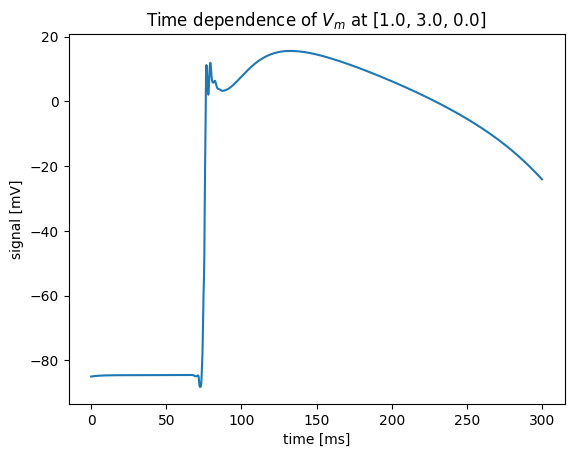

ERROR:wslink.protocol:Exception raised
ERROR:wslink.protocol:KeyError('7d5869e821ec66ae9b7f4e888571fdd4_13957d')
ERROR:wslink.protocol:Traceback (most recent call last):
  File "/home/drvinko/miniconda3/envs/diplomski/lib/python3.11/site-packages/wslink/protocol.py", line 332, in onMessage
    results = func(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^
  File "/home/drvinko/miniconda3/envs/diplomski/lib/python3.11/site-packages/trame_vtk/modules/vtk/protocols/local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "/home/drvinko/miniconda3/envs/diplomski/lib/python3.11/site-packages/trame_vtk/modules/vtk/serializers/synchronization_context.py", line 30, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
                ~~~~~~~~~~~~~~~~~~~~~^^^^^^^
KeyError: '7d5869e821ec66ae9b7f4e888571fdd4_13957d'



In [ ]:
model.plot_signal()